In [3]:
import matplotlib.pyplot as plt
import os, csv
from collections import defaultdict
from sklearn.metrics import f1_score

In [ ]:
model = InceptionV4()
model.load_state_dict(torch.load("model_CE-2.pt", map_location=torch.device('cpu')))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

test_dataset = ImageDataset("./data/resized_images", "test", ToTensor())
batch_size = 64
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0)

predictions = []
true = []
with torch.no_grad():
    for batch_x, batch_y in tqdm(test_dataloader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_pred = model(batch_x)

        predictions.append(y_pred)
        true.append(batch_y)

predictions = torch.cat(predictions, axis=0)
true = torch.cat(true, axis=0)
test_acc = (predictions.argmax(dim=1) == true).float().mean().item()
print(f"Test Accuracy: {test_acc}")

In [22]:
# Save predictions to a CSV file
predictions_CE = predictions.argmax(dim=1).cpu().numpy()
true_CE = true.cpu().numpy()
with open('predictions_CE.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['True Label', 'Predicted Label'])
    for t, p in zip(true_CE, predictions_CE):
        writer.writerow([t, p])

In [ ]:
def calculate_f1_score(csv_file):

    true_labels = []
    predicted_labels = []

    with open(csv_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            true_label = int(row['True Label'])
            predicted_label = int(row['Predicted Label'])

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)

    f1_micro = f1_score(true_labels, predicted_labels, average='micro')
    f1_macro = f1_score(true_labels, predicted_labels, average='macro')

    return f1_micro, f1_macro

In [ ]:
f1_micro_CE, f1_macro_CE = calculate_f1_score('/content/Car-make-classification/predictions_CE.csv')
f1_micro_FL, f1_macro_FL = calculate_f1_score('/content/Car-make-classification/predictions_FL.csv')

print("Micro CE:", f1_micro_CE)
print("Macro CE:", f1_macro_CE)
print("Micro FL:", f1_micro_FL)
print("Macro FL:", f1_macro_FL)

In [1]:
def calculate_accuracy_per_class(csv_file):

    correct_predictions = defaultdict(int)
    total_predictions = defaultdict(int)

    with open(csv_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            true_label = int(row['True Label'])
            predicted_label = int(row['Predicted Label'])

            total_predictions[true_label] += 1
            if true_label == predicted_label:
                correct_predictions[true_label] += 1

    # Calculate accuracy per class
    accuracies = {}
    for label in total_predictions:
        accuracies[label] = correct_predictions[label] / total_predictions[label]

    return accuracies

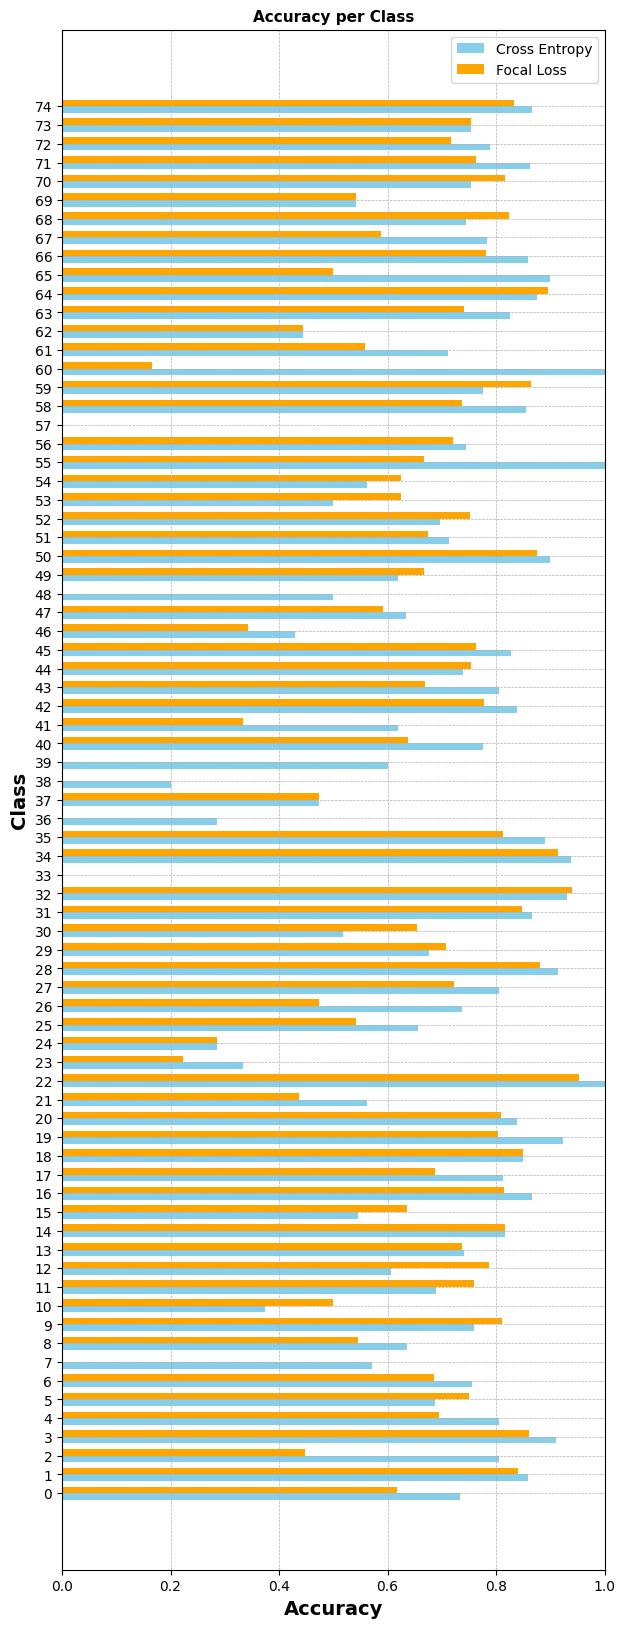

In [9]:
def plot_accuracies(accuracies_1, accuracies_2):
    accuracies_model1 = calculate_accuracy_per_class(accuracies_1)
    accuracies_model2 = calculate_accuracy_per_class(accuracies_2)

    labels = sorted(accuracies_model1.keys())
    accuracy_values_model1 = [accuracies_model1[label] for label in labels]
    accuracy_values_model2 = [accuracies_model2[label] for label in labels]

    plt.figure(figsize=(7, 20))
    bar_width = 0.35
    index = range(len(labels))
    
    plt.barh(index, accuracy_values_model1, bar_width, label='Cross Entropy', color='skyblue')
    plt.barh([i + bar_width for i in index], accuracy_values_model2, bar_width, label='Focal Loss', color='orange')

    plt.ylabel('Class', fontsize=14, fontweight='bold')
    plt.xlabel('Accuracy', fontsize=14, fontweight='bold')
    plt.title('Accuracy per Class', fontsize=11, fontweight='bold')
    plt.yticks([i + bar_width / 2 for i in index], labels)
    plt.xlim(0, 1)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.savefig('class_accuracy.png', format='png')

plot_accuracies('predictions_CE.csv', 'predictions_FL.csv')

In [50]:
def top_k_accuracy(predictions, true, k):
    top_k_preds = predictions.topk(k, dim=1).indices
    correct = top_k_preds.eq(true.view(-1, 1).expand_as(top_k_preds))
    top_k_acc = correct.sum().float()/true.size(0)
    return top_k_acc

val_acc = (predictions.argmax(dim=1) == true).float().mean()
val_acc_top_5 = top_k_accuracy(predictions, true, 5)
val_acc_top_10 = top_k_accuracy(predictions, true, 10)

print(f"Accuracy: {val_acc},\n top 5 acc: {val_acc_top_5}, top 10 acc: {val_acc_top_10}")

Accuracy: 0.8036144375801086,
 top 5 acc: 0.9444444179534912, top 10 acc: 0.9742971658706665


In [ ]:
test_accuracy_CE = [0.0739, 0.0774, 0.0826, 0.0853, 0.1039, 0.0987, 0.0972, 0.1142, 0.1173, 0.1453,
            0.1367, 0.1737, 0.1872, 0.2117, 0.2102, 0.2514, 0.2899, 0.3112, 0.3212, 0.3864,
            0.3812, 0.4224, 0.4017, 0.4803, 0.5018, 0.5295, 0.5547, 0.5492, 0.5896, 0.6033,
            0.6171, 0.6044, 0.6705, 0.6451, 0.6464, 0.6506, 0.7091, 0.6595, 0.6728, 0.6913,
            0.6827, 0.6771, 0.7313, 0.6803, 0.7281, 0.7328, 0.7615, 0.7097, 0.7294, 0.7432,
            0.7615, 0.7571, 0.7626, 0.7553, 0.7534, 0.7709, 0.7283, 0.7728, 0.7901, 0.7830,
            0.7858, 0.7413, 0.7640, 0.7583, 0.7549, 0.7901, 0.7606, 0.7836, 0.7441, 0.7780,
            0.7753, 0.8052, 0.7862, 0.7816, 0.7854, 0.8064, 0.8051, 0.7994, 0.8079, 0.7670]

top5_accuracy_CE = [0.2721, 0.2893, 0.2883, 0.3079, 0.3382, 0.3369, 0.3346, 0.3442, 0.3465, 0.3967,
                  0.3679, 0.4168, 0.4410, 0.4730, 0.4485, 0.5389, 0.5756, 0.5982, 0.6191, 0.6749,
                  0.6747, 0.6966, 0.7013, 0.7618, 0.7858, 0.7977, 0.8348, 0.8073, 0.8297, 0.8525,
                  0.8632, 0.8541, 0.8890, 0.8783, 0.8681, 0.8794, 0.9104, 0.8870, 0.8974, 0.9043,
                  0.8913, 0.8841, 0.9210, 0.9024, 0.9175, 0.9268, 0.9316, 0.9108, 0.9170, 0.9288,
                  0.9268, 0.9292, 0.9319, 0.9333, 0.9244, 0.9325, 0.9194, 0.9348, 0.9402, 0.9435,
                  0.9385, 0.9215, 0.9279, 0.9304, 0.9274, 0.9388, 0.9302, 0.9369, 0.9233, 0.9357,
                  0.9403, 0.9462, 0.9419, 0.9345, 0.9416, 0.9470, 0.9452, 0.9452, 0.9478, 0.9348]

top10_accuracy_CE = [0.4227, 0.4509, 0.4469, 0.4695, 0.4928, 0.5003, 0.5039, 0.5094, 0.5014, 0.5591,
                   0.5262, 0.5750, 0.6024, 0.6349, 0.6012, 0.6967, 0.7178, 0.7404, 0.7658, 0.8017,
                   0.8024, 0.8207, 0.8255, 0.8637, 0.8762, 0.8895, 0.9126, 0.9003, 0.9123, 0.9218,
                   0.9273, 0.9207, 0.9415, 0.9339, 0.9351, 0.9389, 0.9527, 0.9423, 0.9490, 0.9533,
                   0.9443, 0.9410, 0.9621, 0.9523, 0.9634, 0.9651, 0.9681, 0.9541, 0.9559, 0.9665,
                   0.9644, 0.9648, 0.9660, 0.9669, 0.9639, 0.9653, 0.9613, 0.9713, 0.9727, 0.9732,
                   0.9700, 0.9657, 0.9656, 0.9679, 0.9664, 0.9711, 0.9664, 0.9696, 0.9625, 0.9679,
                   0.9744, 0.9742, 0.9731, 0.9676, 0.9715, 0.9747, 0.9742, 0.9723, 0.9754, 0.9703]



epochs = range(1, 81)

plt.figure(figsize=(10, 6))
plt.plot(epochs, test_accuracy_CE, label='Top-1 Accuracy')
plt.plot(epochs, top5_accuracy_CE, label='Top-5 Accuracy')
plt.plot(epochs, top10_accuracy_CE, label='Top-10 Accuracy')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy with Cross-Entropy Loss', fontsize=13, fontweight='bold')
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
#plt.show()

plt.savefig('model_accuracy_CrossEntropy.png', format='png')

In [ ]:
test_accuracy_FL = [0.07417324930429459, 0.07390547543764114, 0.07015664875507355, 0.08274199813604355, 0.09546124190092087, 0.1006828173995018, 0.0824742242693901, 0.1239791139960289, 0.1233096793293953, 0.13736778497695923, 0.14968536794185638,
            0.20056232810020447, 0.19226133823394775, 0.19708126783370972, 0.2146204262971878, 0.2467532455921173, 0.3076716959476471, 0.27660998702049255, 0.21595929563045502, 0.36644798517227173, 0.39737582206726074, 0.3933592140674591,
            0.39362698793411255, 0.38974428176879883, 0.47556567192077637, 0.5046190619468689, 0.48172444105148315, 0.5652697682380676, 0.5043513178825378, 0.5688847303390503, 0.5892354846000671, 0.5553621649742126, 0.5544249415397644, 0.586691677570343,
            0.5384924411773682, 0.6280626654624939, 0.63542640209198, 0.550943911075592, 0.6381041407585144, 0.6679608821868896, 0.6699692010879517, 0.6956754326820374, 0.6792073845863342, 0.6643459796905518, 0.6919265985488892, 0.680278480052948,
            0.6887133121490479, 0.6407818794250488, 0.7034409046173096, 0.7129468321800232, 0.7015664577484131, 0.7146873474121094, 0.7205783724784851, 0.733029842376709, 0.7252644300460815, 0.7306199073791504, 0.6946043372154236, 0.7212477922439575,
            0.735038161277771, 0.7002276182174683, 0.7488284707069397, 0.7288793325424194, 0.7169634103775024, 0.6960771083831787, 0.735305905342102, 0.7618154883384705, 0.746954083442688, 0.7552550435066223, 0.7336992621421814, 0.7433391213417053,
            0.7349042296409607, 0.7511045336723328, 0.7620832920074463, 0.7772124409675598, 0.7709197998046875, 0.7461507320404053, 0.7610121965408325, 0.7512384653091431, 0.7497656941413879, 0.7745347023010254]

top5_accuracy_FL = [0.2755388915538788, 0.2945508062839508, 0.2901325523853302, 0.296291321516037, 0.32373809814453125, 0.3418128192424774, 0.3019145727157593, 0.37421339750289917, 0.35466593503952026, 0.38612931966781616, 0.41130003333091736, 0.4639175236225128,
                  0.45708930492401123, 0.4600348174571991, 0.4979247450828552, 0.5477306246757507, 0.6251171231269836, 0.5690186023712158, 0.5348774790763855, 0.6846967339515686, 0.7081269025802612, 0.7244610786437988, 0.7004953622817993, 0.7031731009483337,
                  0.7851117849349976, 0.7934127449989319, 0.7735975384712219, 0.833712637424469, 0.7896639108657837, 0.8318382501602173, 0.8483062982559204, 0.8339804410934448, 0.8347837328910828, 0.8481724262237549, 0.8252778053283691, 0.876288652420044,
                  0.8781630396842957, 0.8208595514297485, 0.8774936199188232, 0.890212893486023, 0.8970410823822021, 0.9096264243125916, 0.9002543687820435, 0.8883384466171265, 0.9077520370483398, 0.9025304317474365, 0.9010576605796814, 0.8766903281211853,
                  0.9125719666481018, 0.9129735827445984, 0.9069486856460571, 0.9140446782112122, 0.9204712510108948, 0.9196679592132568, 0.9171240925788879, 0.91913241147995, 0.9049404263496399, 0.9223456978797913, 0.9188646078109741, 0.9125719666481018,
                  0.9286383390426636, 0.922211766242981, 0.9175257682800293, 0.9116347432136536, 0.9228812456130981, 0.9327888488769531, 0.9251573085784912, 0.9307805299758911, 0.9208729267120361, 0.9183290600776672, 0.9231489896774292, 0.9223456978797913,
                  0.9303788542747498, 0.9349310398101807, 0.9310483336448669, 0.9200696349143982, 0.9311822056770325, 0.9187307357788086, 0.9279689192771912, 0.9357343316078186]

top10_accuracy_FL = [0.4430311918258667, 0.4525371491909027, 0.45213547348976135, 0.4612397849559784, 0.48292943835258484, 0.504083514213562, 0.45521488785743713, 0.546927273273468, 0.5192127227783203, 0.55174720287323, 0.5858883261680603, 0.6298031806945801,
                   0.6228410601615906, 0.6202971935272217, 0.6520283818244934, 0.6912571787834167, 0.7725264430046082, 0.7212477922439575, 0.6971482038497925, 0.8117552399635315, 0.8310349583625793, 0.8452269434928894, 0.8295621871948242, 0.8248761296272278,
                   0.8809747099876404, 0.8912839293479919, 0.8710670471191406, 0.9137769341468811, 0.8819118738174438, 0.912304162979126, 0.9224795699119568, 0.916588544845581, 0.9177935123443604, 0.9204712510108948, 0.9124380350112915, 0.938144326210022,
                   0.9398848414421082, 0.905208170413971, 0.9389476180076599, 0.945240318775177, 0.9467130899429321, 0.9564868211746216, 0.95313960313797, 0.9416253566741943, 0.9520685076713562, 0.9567545652389526, 0.9505957961082458, 0.9392154216766357,
                   0.9579595327377319, 0.9587628841400146, 0.95313960313797, 0.9614406228065491, 0.9651894569396973, 0.9630472660064697, 0.957156240940094, 0.9618422389030457, 0.9539429545402527, 0.960235595703125, 0.959967851638794, 0.9609050750732422,
                   0.9667961001396179, 0.9630472660064697, 0.9610389471054077, 0.9607711434364319, 0.9627794623374939, 0.9673316478729248, 0.9635828137397766, 0.9673316478729248, 0.9634488821029663, 0.9623777866363525, 0.9631811380386353, 0.9597001075744629,
                   0.9655910730361938, 0.9678671956062317, 0.9669299721717834, 0.960235595703125, 0.9700093269348145, 0.9595661759376526, 0.965055525302887, 0.9665282964706421]



epochs = range(1, 81)

plt.figure(figsize=(10, 6))
plt.plot(epochs, test_accuracy_FL, label='Top-1 Accuracy')
plt.plot(epochs, top5_accuracy_FL, label='Top-5 Accuracy')
plt.plot(epochs, top10_accuracy_FL, label='Top-10 Accuracy')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy with Focal Loss', fontsize=13, fontweight='bold')
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
#plt.show()

plt.savefig('model_accuracy_FocalLoss.png', format='png')

In [ ]:
train_loss_CE = [3.908, 3.768, 3.798, 3.459, 3.587, 3.585, 3.476, 3.749, 3.593, 3.628,
              4.006, 3.301, 2.585, 3.123, 2.819, 2.923, 2.129, 2.371, 1.587, 2.659,
              1.795, 1.357, 1.879, 1.371, 1.994, 1.908, 1.903, 0.960, 0.688, 0.996,
              1.155, 1.325, 0.931, 0.458, 0.445, 1.515, 0.566, 0.864, 1.478, 0.386,
              0.481, 0.653, 0.689, 0.720, 0.459, 0.421, 0.221, 0.346, 1.814, 0.085,
              0.119, 0.155, 0.423, 0.625, 0.045, 0.454, 0.209, 0.291, 0.170, 0.210,
              0.059, 0.370, 0.130, 0.303, 0.120, 0.724, 0.470, 0.158, 0.196, 0.326,
              0.156, 0.282, 0.629, 0.468, 0.134, 0.650, 0.356, 0.206, 0.479, 0.065]

validation_loss_CE = [3.842, 3.776, 3.782, 3.698, 3.611, 3.649, 3.605, 3.552, 3.697, 3.394,
        3.474, 3.285, 3.222, 3.308, 3.369, 2.944, 2.758, 2.635, 2.561, 2.322,
        2.353, 2.229, 2.326, 1.966, 1.827, 1.738, 1.655, 1.741, 1.558, 1.485,
        1.461, 1.521, 1.231, 1.363, 1.424, 1.435, 1.110, 1.397, 1.297, 1.225,
        1.314, 1.371, 1.063, 1.315, 1.178, 1.106, 0.963, 1.288, 1.141, 1.129,
        1.039, 1.093, 1.076, 1.063, 1.100, 1.006, 1.231, 1.024, 0.955, 0.953,
        1.018, 1.247, 1.115, 1.127, 1.124, 0.987, 1.173, 1.042, 1.384, 1.121,
        1.069, 0.905, 1.017, 1.102, 1.015, 0.948, 0.958, 1.015, 0.939, 1.197]


epochs = range(1, 81)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_CE, label='Training loss')
plt.plot(epochs, validation_loss_CE, label='Validation loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.title('Validation and Training using Cross-Entropy Loss', fontsize=13, fontweight='bold')
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.show()
plt.savefig('train_val_loss_CrossEntropy.png', format='png')

In [ ]:
train_loss_FL = [3.4075671719403813, 3.382658935388758, 3.4452055800778636, 3.011390802237169, 3.308630570897894, 3.0759775511760497, 3.086350922141782, 3.3649577350661812, 3.318470867428662, 2.6220209796379104,
              3.078024340750975, 2.464477277920432, 2.4777674570002395, 2.4785332360059114, 2.4191872842736313, 2.6822285393648153, 1.9463573082306314, 1.441755179696126, 1.6021607607295287, 2.232560254145041,
              1.3406812571018283, 0.8805363618376649, 1.5411373842138163, 0.45232801673090617, 1.4823496933223521, 0.8410327721055261, 1.6352301386622217, 0.45539340678865436, 0.3848992980404621, 0.6788758629596232,
              0.7701562863027045, 1.0405294948971808, 0.5201160907734006, 0.5897585929216396, 0.09588738464216724, 0.7251375170676188, 0.49991099378261605, 0.5031525091969018, 0.7751974993315797, 0.42095436373656686,
              0.37330374583189796, 0.6168962383447985, 0.43842835386147383, 0.31164365745241984, 0.41098026861752696, 0.19511938141462257, 0.5664189202398665, 0.10429347335794534, 1.0904362848165574, 0.08815609082642598,
              0.385064645887632, 0.012932523642183388, 0.10646772314560062, 0.24790837174381586, 0.2482168730894671, 0.31385250342603216, 0.03928830790748318, 0.9285003009113103, 0.2964751579736737, 0.039595975096665084,
              0.0597344956764683, 0.2761071244139308, 0.06229065710984283, 0.3062213262883415, 0.4116891955975225, 0.23216807128066477, 0.08286561380716166, 0.12499596137684044, 0.13720645886612387, 0.032361355816236025,
              0.383717579030653, 0.15115189111657812, 0.7026562325486541, 0.05635441048489536, 0.27456919179771894, 0.4671059555893426, 0.2097772686586357, 0.15668920119196056, 0.006595226521915042, 0.2506736823691353]

validation_loss_FL = [3.368887946685895, 3.3301431353996604, 3.3517437847534923, 3.3002791873317023, 3.2363846709344983, 3.2046309867891685, 3.610406673843115, 3.0126206312355945, 3.120447978373761, 2.962287740964957, 2.8617163301765394,
        2.642155151648902, 2.7719317404820845, 2.9293834829816454, 2.7509921492018585, 2.503836300360861, 2.0851608507317954, 2.423757389036017, 2.6108280918732563, 1.8784392181261227, 1.7534693384380406, 1.6928490638742522,
        1.7929850708438715, 1.8311361462983493, 1.4376970611949043, 1.357306993086015, 1.5404291874244254, 1.1512328865371386, 1.4752114806303167, 1.2092731641310799, 1.0698593962054468, 1.2495489026390243, 1.244479297437532,
        1.1222360368367381, 1.3066006180769616, 0.9728099789350312, 0.9814240562894876, 1.3252207205952862, 1.0017967712519453, 0.9144149740186439, 0.8907638679312464, 0.781251679640061, 0.85512684154943, 0.9486150584886195,
        0.848645720410206, 0.8698313685892486, 0.8586166832895105, 1.0885599779505537, 0.803209136662417, 0.768389824790042, 0.8296801240182973, 0.7790876177409878, 0.7616487325029474, 0.7433420811279023, 0.783659161522363,
        0.7450773951240456, 0.8930026840734449, 0.8104116917320046, 0.7529680669822058, 0.8541499315770573, 0.7277187036173086, 0.7728588334270329, 0.8180573171797768, 0.9034055340644445, 0.7377086300029632, 0.6680277311880904,
        0.744496459838482, 0.6908653969198171, 0.8001236566700097, 0.7591696529270888, 0.7648599141516553, 0.7526654839279152, 0.6856897074872561, 0.6372178713547022, 0.6750251219585874, 0.7852851693576668, 0.6909196443671426,
        0.7694901857733946, 0.7408811303640229, 0.6400025097997797]

epochs = range(1, 81)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_FL, label='Training loss')
plt.plot(epochs, validation_loss_FL, label='Validation loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.title('Validation and Training using Focal Loss', fontsize=13, fontweight='bold')
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.show()
plt.savefig('train_val_loss_Focal.png', format='png')

In [51]:
def count_images_by_class(folder_path):
    class_counts = [0] * 75

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            class_index = int(filename.split('_')[0])
            class_counts[class_index] += 1
    
    return class_counts

In [52]:
folder_path1 = 'data/resized_images/train'
class_counts = count_images_by_class(folder_path1)
print(folder_path1, class_counts)

folder_path2 = 'data/resized_images/test'
class_counts = count_images_by_class(folder_path2)
print(folder_path2, class_counts)

folder_path3 = 'data/resized_images/validation'
class_counts = count_images_by_class(folder_path3)
print(folder_path3, class_counts)

data/resized_images/train [118, 201, 161, 236, 83, 92, 296, 14, 36, 135, 49, 59, 248, 592, 76, 19, 224, 47, 60, 226, 465, 69, 44, 19, 14, 199, 47, 71, 1201, 319, 195, 643, 937, 10, 845, 127, 22, 34, 13, 13, 133, 57, 299, 431, 288, 490, 84, 226, 14, 253, 587, 208, 360, 22, 30, 16, 381, 16, 228, 168, 17, 120, 20, 469, 241, 22, 288, 208, 299, 47, 498, 360, 350, 120, 407]
data/resized_images/test [60, 107, 67, 122, 36, 32, 143, 7, 11, 58, 16, 29, 117, 282, 38, 11, 97, 16, 20, 117, 210, 32, 21, 9, 7, 96, 19, 36, 555, 164, 87, 321, 452, 7, 394, 64, 7, 19, 5, 5, 58, 21, 149, 196, 142, 233, 35, 115, 6, 129, 258, 80, 181, 16, 16, 6, 165, 4, 110, 89, 6, 52, 9, 212, 105, 10, 128, 97, 137, 24, 219, 160, 166, 61, 179]
data/resized_images/validation [48, 86, 82, 103, 44, 50, 135, 5, 22, 64, 26, 25, 108, 266, 32, 6, 115, 27, 37, 96, 228, 31, 20, 6, 4, 86, 25, 33, 570, 119, 99, 293, 439, 3, 405, 54, 11, 11, 4, 5, 70, 34, 134, 208, 128, 217, 45, 95, 3, 111, 300, 110, 145, 5, 11, 8, 195, 10, 104, 71, 7,